# The importance of good co-ordinates when using MACEst

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from macest.classification import models as clmod
from macest.classification import plots as clplot

In [3]:
# sns.set_context("talk")
# sns.set_context("poster")
sns.set_context("notebook")
sns.set_style('darkgrid')

In [4]:
cols = ['lettr',
'x-box',
'y-box',
'width',
'high',
'onpix',
'x-bar',
'y-bar',
'x2bar',
'y2bar',
'xybar',
'x2ybr',
'xy2br',
'x-ege',
'xegvy',
'y-ege',
'yegvx']

### We will try to add confidence to a classic ML challenge, classifying images of letters based upon some statistical attributes (https://archive.ics.uci.edu/ml/datasets/letter+recognition)

Before running this stage, please download the `letters.data` file from the above URL and place this within the `data` folder in the root directory of this project.

In [5]:
letters_df = pd.read_csv("../../data/letter-recognition.data", header=None, names=cols).sample(frac=1)
letters_df.reset_index(drop=True, inplace=True)

In [6]:
y = letters_df['lettr']
X = letters_df.drop('lettr', axis =1)

### In the original feature space we have lots of correlated variables, and the feature importance is unlikely to be even amongst all of them

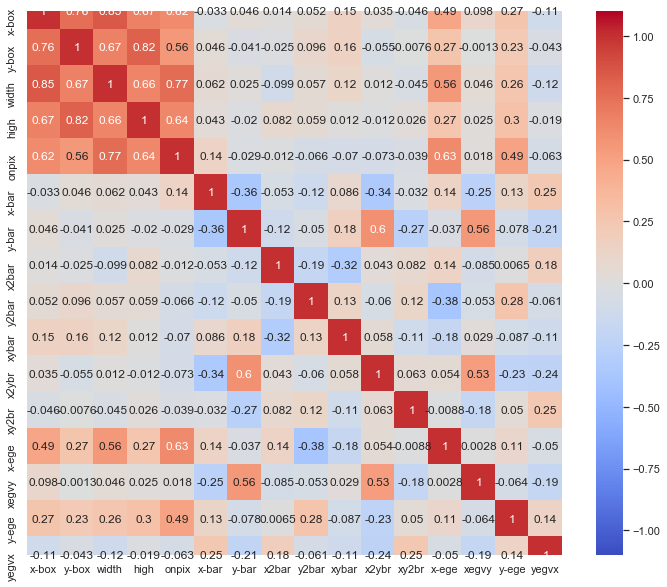

In [7]:
plt.figure(figsize = (12,10))
sns.heatmap(X.corr(),
            cmap = 'coolwarm',
            annot = True,
            vmin = -1.1, vmax =1.1)

In [8]:
X = X/16

In [9]:
enc = LabelEncoder()
y = enc.fit_transform(y)

In [10]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.66, random_state=0)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.4, random_state=0)

In [11]:
print(X_pp_train.shape[0])
print(X_conf_train.shape[0])
print(X_cal.shape[0])
print(X_test.shape[0])

6800
7920
3168
2112


In [12]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
print(model.score(X_pp_train, y_pp_train))
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))
print(model.score(X_test, y_test))

1.0
0.9463383838383839
0.9441287878787878
0.9351325757575758


### We will use the L2 metric, this is implictly saying that our measure of similarity between data points is the euclidean distance in feature space

In [14]:
param_bounds = clmod.SearchBounds(k_bounds = (3,50))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1000))
optimiser_args = dict(popsize = 25)

In [15]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

## Unseen data

In [16]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf = model.predict_proba(X_test)
rf_point_prediction_conf = np.amax(rf_conf, axis=1)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test)

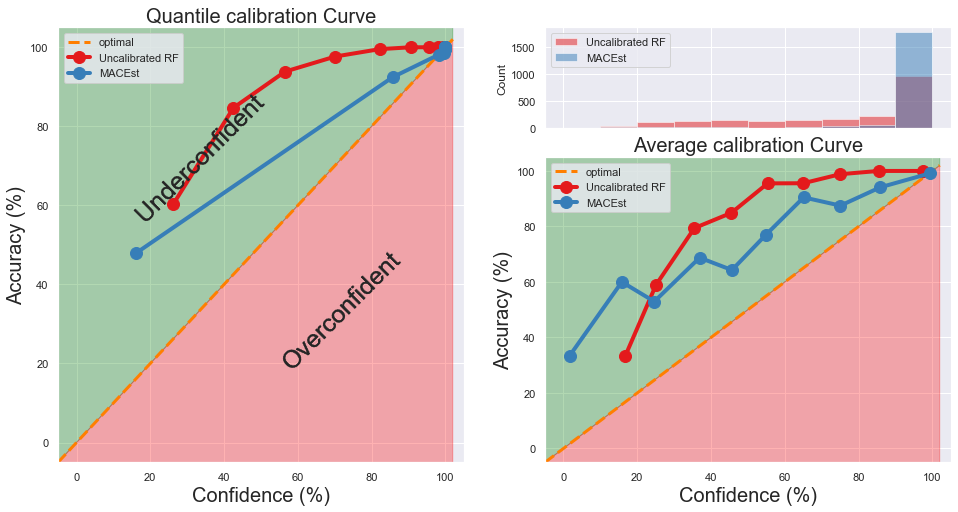

In [17]:
clplot.plot_calibration_curve([rf_point_prediction_conf,
                              macest_point_prediction_conf], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

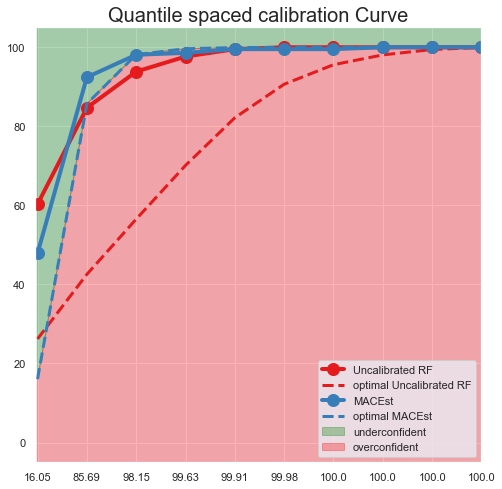

In [18]:
clplot.plot_quantile_spaced_calibration_curve([rf_point_prediction_conf,
                             macest_point_prediction_conf,
                                ], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

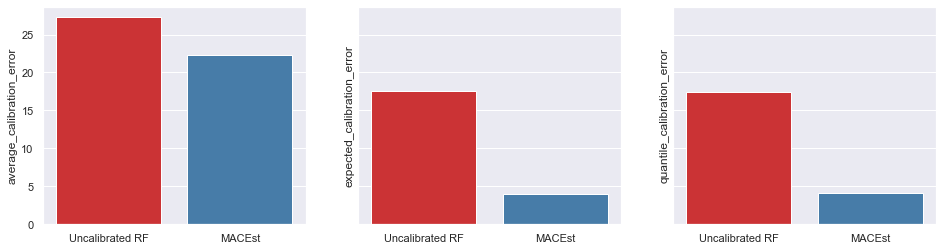

In [19]:
clplot.plot_calibration_metrics([rf_point_prediction_conf,
                             macest_point_prediction_conf,
                                ], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

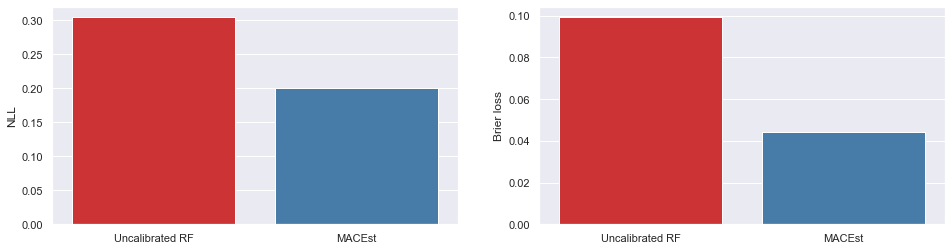

In [20]:
clplot.plot_forecast_metrics([rf_point_prediction_conf,
                             macest_point_prediction_conf], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

We see that MACEst performs better than the raw estimates from the random forest however it's still not great, let's try inducing a better co-ordinate system 

### PCA

In [21]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.66, random_state=0)

pca = PCA(n_components=0.95, whiten = True)
pca.fit(X_pp_train)

X_pp_train = pca.transform(X_pp_train)
X_conf_train = pca.transform(X_conf_train)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.4, random_state=0)

In [22]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
X_cal.shape

(3168, 12)

In [24]:
print(model.score(X_pp_train, y_pp_train))
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))
print(model.score(X_test, y_test))

1.0
0.9186868686868687
0.9201388888888888
0.9034090909090909


### We are now saying points are similar if the euclidean distance between their projection is whitned pca space (similar to mahalanobis) is small

In [25]:
neighbour_search_params = clmod.HnswGraphArgs(init_args = dict(method = 'hnsw',
                                                               space = 'l2'))

In [26]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

In [27]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf = model.predict_proba(X_test)
rf_point_prediction_conf = np.amax(rf_conf, axis=1)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test)

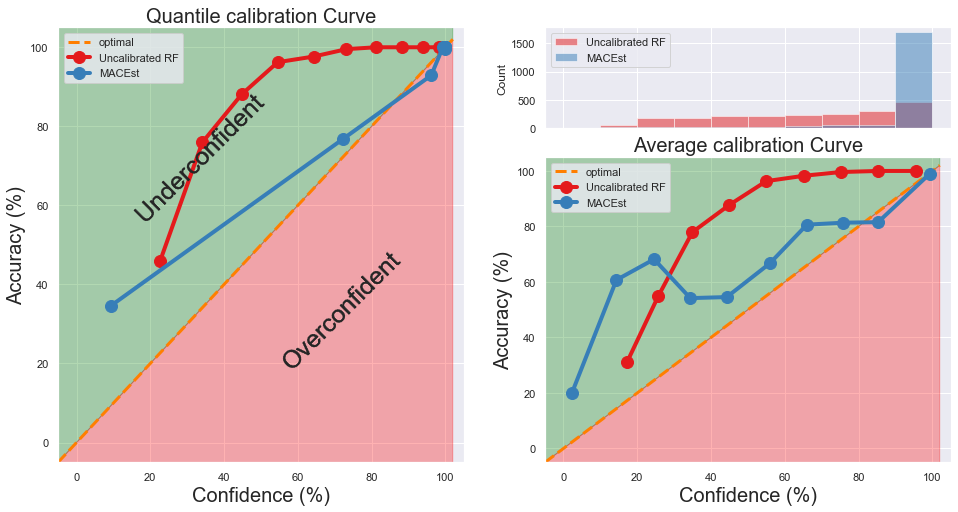

In [28]:
clplot.plot_calibration_curve([rf_point_prediction_conf,macest_point_prediction_conf], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

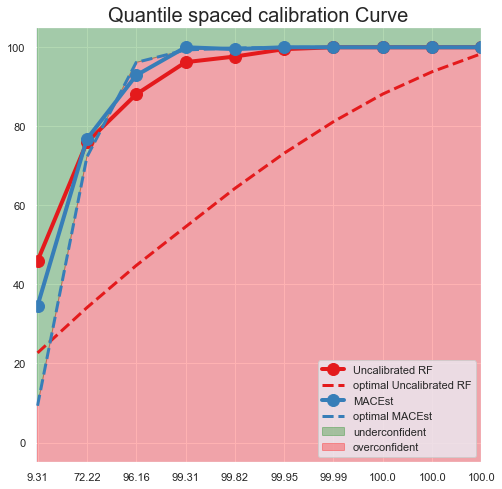

In [29]:
clplot.plot_quantile_spaced_calibration_curve([rf_point_prediction_conf, macest_point_prediction_conf], 
                                              ['Uncalibrated RF','MACEst' ],
                                              preds, y_test)

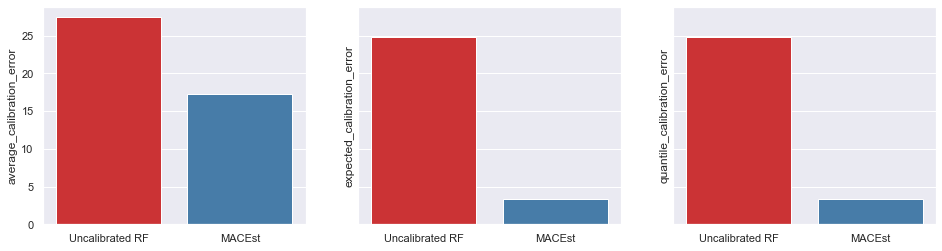

In [30]:
clplot.plot_calibration_metrics([rf_point_prediction_conf, macest_point_prediction_conf], 
                                 ['Uncalibrated RF','MACEst' ],
                                 preds, y_test)

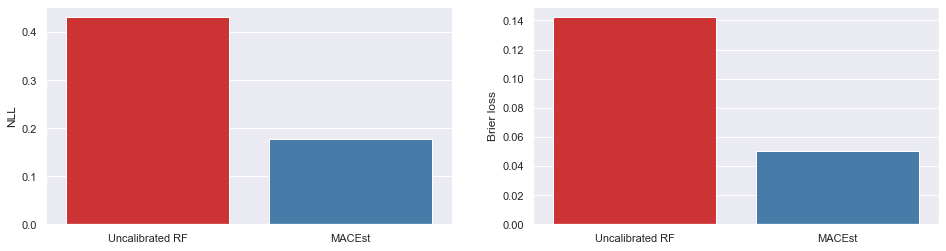

In [31]:
clplot.plot_forecast_metrics([rf_point_prediction_conf,
                             macest_point_prediction_conf,], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

## That is better but still not great, can we do better ?

MACEst works by finding a set of nearest neighbours and then uses the distance to these k neighbours as a proxy for the epistemic uncertainty, because of this paradigm the natural metric to one which induces a good nearest neighbour distance. This method exists and is known as neighbourhood component analysis (https://www.cs.toronto.edu/~hinton/absps/nca.pdf)
#### Let's compare the results if we use this metric

In [32]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.66, random_state=0)

nca = NeighborhoodComponentsAnalysis(n_components = X_pp_train.shape[1] ,
                                     max_iter = 30,
                                     verbose =1)
nca.fit(X_pp_train, y_pp_train)

X_pp_train = nca.transform(X_pp_train)
X_conf_train = nca.transform(X_conf_train)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.3, random_state=0)

Finding most discriminative components... done in  0.04s
[NeighborhoodComponentsAnalysis]
[NeighborhoodComponentsAnalysis]  Iteration      Objective Value    Time(s)
[NeighborhoodComponentsAnalysis] ------------------------------------------
[NeighborhoodComponentsAnalysis]          1         6.037801e+03       2.66
[NeighborhoodComponentsAnalysis]          1         6.088463e+03       2.71
[NeighborhoodComponentsAnalysis]          2         6.363376e+03       2.59
[NeighborhoodComponentsAnalysis]          3         6.427933e+03       2.67
[NeighborhoodComponentsAnalysis]          4         6.482959e+03       2.73
[NeighborhoodComponentsAnalysis]          5         6.538582e+03       2.67
[NeighborhoodComponentsAnalysis]          6         6.561330e+03       2.56
[NeighborhoodComponentsAnalysis]          7         6.578224e+03       2.86
[NeighborhoodComponentsAnalysis]          8         6.592906e+03       2.68
[NeighborhoodComponentsAnalysis]          9         6.602848e+03       2.8

/Users/mattrowe/Code/mace/.env/lib/python3.6/site-packages/sklearn/neighbors/_nca.py:236: ConvergenceWarning: [NeighborhoodComponentsAnalysis] NCA did not converge: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  ConvergenceWarning)


In [33]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

In [35]:
print(model.score(X_pp_train, y_pp_train))
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))
print(model.score(X_test, y_test))

1.0
0.9362373737373737
0.9366883116883117
0.9292929292929293


In [36]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf = model.predict_proba(X_test)
rf_point_prediction_conf = np.amax(rf_conf, axis=1)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test)

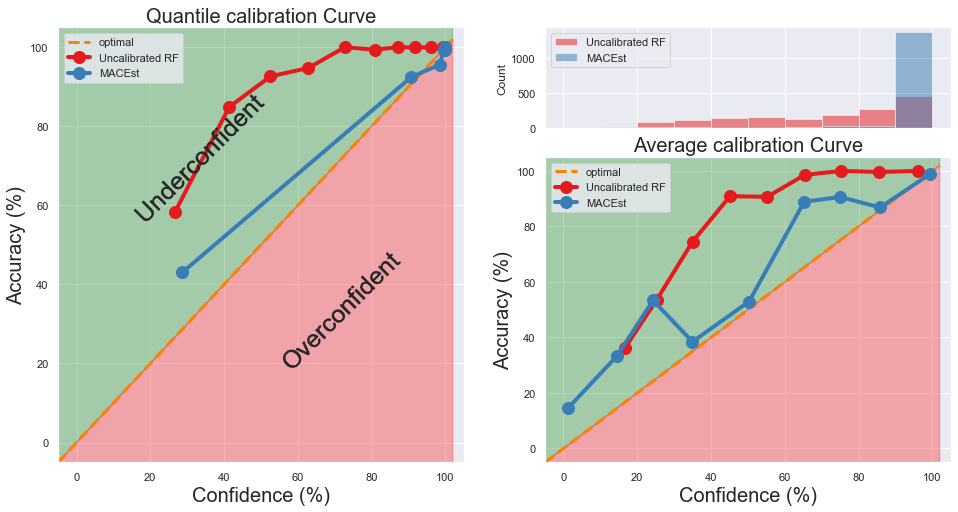

In [37]:
clplot.plot_calibration_curve([rf_point_prediction_conf,
                              macest_point_prediction_conf,], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

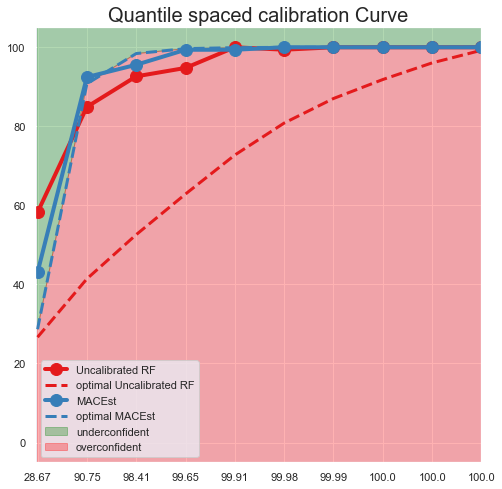

In [38]:
clplot.plot_quantile_spaced_calibration_curve([rf_point_prediction_conf, macest_point_prediction_conf], 
                                              ['Uncalibrated RF', 'MACEst'],
                                              preds, y_test)

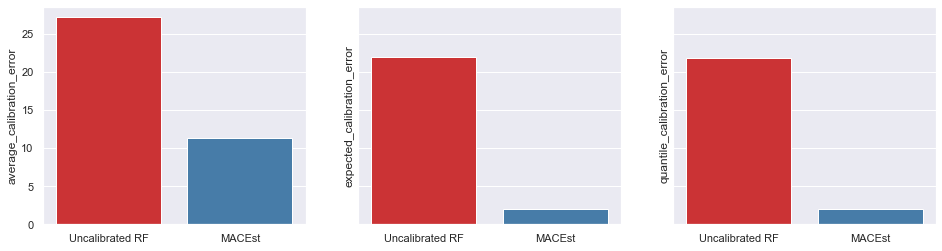

In [39]:
clplot.plot_calibration_metrics([rf_point_prediction_conf,
                                 macest_point_prediction_conf], 
                                 ['Uncalibrated RF','MACEst' ],
                                 preds, y_test)

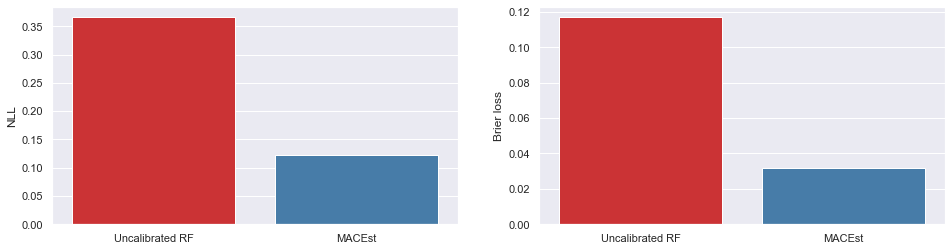

In [40]:
clplot.plot_forecast_metrics([rf_point_prediction_conf,
                              macest_point_prediction_conf,], 
                              ['Uncalibrated RF','MACEst' ],
                              preds, y_test)

In this metric we see that MACEst works very well